In [4]:
import pandas as pd
import nltk
import re

In [5]:
stopwords = nltk.corpus.stopwords.words('english')

In [42]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()

In [34]:
from nltk.tokenize import TreebankWordTokenizer, SpaceTokenizer
tokenizer = TreebankWordTokenizer()

In [43]:
tokenizer.tokenize("Hello, My Name is Guy (Really!)")

['Hello', ',', 'My', 'Name', 'is', 'Guy', '(', 'Really', '!', ')']

In [233]:
def tokenize_only(text):
    tokens = tokenizer.tokenize(text)
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = [token for token in tokens if (re.search('[a-zA-Z]', token) 
                                                     and len(token) > 1 
                                                     and token.find('`') == -1)]
    
    return filtered_tokens

def tokenize_and_stem(text):
    tokens = tokenize_only(text)
    stems = map(stemmer.stem, tokens)
    return stems

In [234]:
tokenize_only("Hello, My Name is Guy (Really!)")

['Hello', 'My', 'Name', 'is', 'Guy', 'Really']

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [269]:
df = pd.read_csv('../data/wiki/wiki.csv.gz', encoding='utf8', index_col=None)

In [270]:
df['text'] = df.text.str[:3000]

In [238]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for doc_text in df.text:
    allwords_stemmed = tokenize_and_stem(doc_text) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(doc_text)
    totalvocab_tokenized.extend(allwords_tokenized)

In [239]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [240]:
vocab_frame.head(10)

,words
may,may
refer,refer
to,to
number,number
the,the
integ,integer
between,between
and,and
year,year
year,year


In [241]:
len(vocab_frame)

336092

## Tf-idf and document similarity

In [528]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=12, min_df=3, 
                                   stop_words='english',
                                   tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.text)

print(tfidf_matrix.shape)

Wall time: 13.6 s
(835, 10124)


In [529]:
terms = tfidf_vectorizer.get_feature_names()

In [530]:
len(terms)

10124

In [531]:
len(vocab_frame)

336092

In [532]:
terms = tfidf_vectorizer.get_feature_names()

In [536]:
idx = 2742
terms[idx]

u'diagnos'

In [537]:
terms[800]

u'area border'

In [538]:
vocab_frame.ix[terms[idx]].head(5)

,words
diagnos,diagnosed
diagnos,diagnosed
diagnos,diagnosed
diagnos,diagnoses
diagnos,diagnosed


## Lets cluster!

In [539]:
from sklearn.cluster import KMeans

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 620 ms


In [540]:
len(clusters)

835

## But what did we get?

In [541]:
clustered = df.join(pd.DataFrame({'cluster': clusters}))

In [542]:
clustered.head()

,name,text,cluster
0,0,"0 may refer to: 0 (number) , the integer b...",0
1,11.22.63,11.22.63 is an American science fiction ...,5
2,2016,2016 has been designated as: Inte...,4
3,4chan,4chan is an English-language image...,8
4,8chan,"8chan, also called Infinitechan, is a...",7


In [543]:
len(km.cluster_centers_[1])

10124

In [544]:
order_centroids = km.cluster_centers_.argsort()

In [545]:
order_centroids

array([[10123,  5672,  5671, ...,  3310,  4481,  7596],
       [    0,  6177,  6176, ...,  4035,  2446,   727],
       [    0,  5817,  5816, ...,  3367,  5681,  6988],
       ..., 
       [    0,  5902,  5901, ...,  9132,  6410,  6533],
       [    0,  5936,  5935, ...,  7037,  6250,  3860],
       [    0,  6355,  6354, ...,  1918,  9647,  6630]], dtype=int64)

In [546]:
term_words = vocab_frame.ix[terms[idx]]

In [547]:
term_words['words'].value_counts().keys()[0]

u'diagnosed'

In [548]:
cluster_names = []

for cluster_centeroids in order_centroids:
    words = []
    for ind in cluster_centeroids[-6:]:
        term_words = vocab_frame.ix[terms[ind].split(' ')]
        
        best_word = term_words['words'].value_counts().keys()[0]
        
        words.append(best_word)
        
    cluster_names.append(', '.join(words))

In [549]:
cluster_names

[u'ontology, metaphysics, Prussia, epistemology, Hulk, REDIRECT',
 u'dinosaurs, shark, cat, gorilla, crocodile, apes',
 u'crew, Muhammad, Sudan, Ethiopia, Mauritius, Plato',
 u'cable, WWE, Championship, automobile, Wrestling, Volkswagen',
 u'procedure, managemen, antibiotics, amphetamine, vaccine, benzodiazepines',
 u'hop, No., certified, guitar, guitarist, DJ',
 u'Wikipedia, HTML, iPhone, Google, email, browser',
 u'Aboriginal, Finland, Ontario, Texas, Norway, Ohio',
 u'Ukraine, Hungary, Colombia, Poland, Netherlands, fruit',
 u'Pornhub, porn, penis, clitoris, vaginal, orgasm']

In [550]:
clustered['cluster_name'] =clustered.cluster.map(lambda cluster: cluster_names[cluster])

In [551]:
clustered.head(10)

,name,text,cluster,cluster_name
0,0,"0 may refer to: 0 (number) , the integer b...",0,"ontology, metaphysics, Prussia, epistemology, ..."
1,11.22.63,11.22.63 is an American science fiction ...,5,"hop, No., certified, guitar, guitarist, DJ"
2,2016,2016 has been designated as: Inte...,4,"procedure, managemen, antibiotics, amphetamine..."
3,4chan,4chan is an English-language image...,8,"Ukraine, Hungary, Colombia, Poland, Netherland..."
4,8chan,"8chan, also called Infinitechan, is a...",7,"Aboriginal, Finland, Ontario, Texas, Norway, Ohio"
5,Aaliyah,"Aaliyah Dana Haughton ( ; January 16,...",5,"hop, No., certified, guitar, guitarist, DJ"
6,ABBA,ABBA (stylised ᗅᗺᗷᗅ ; ) were a Swed...,5,"hop, No., certified, guitar, guitarist, DJ"
7,Abraham,"Abraham ( ; , ), originally Abra...",9,"Pornhub, porn, penis, clitoris, vaginal, orgasm"
8,Achilles,Achilles and the Nereid Cymothoe: Attic ...,6,"Wikipedia, HTML, iPhone, Google, email, browser"
9,Adderall,Adderall is a co mbination drug con...,4,"procedure, managemen, antibiotics, amphetamine..."


In [502]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [503]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [307]:
import seaborn as sns

In [308]:
#set up colors per clusters using a dict
cluster_colors = sns.color_palette(n_colors=len(clusters))


In [309]:
%matplotlib inline

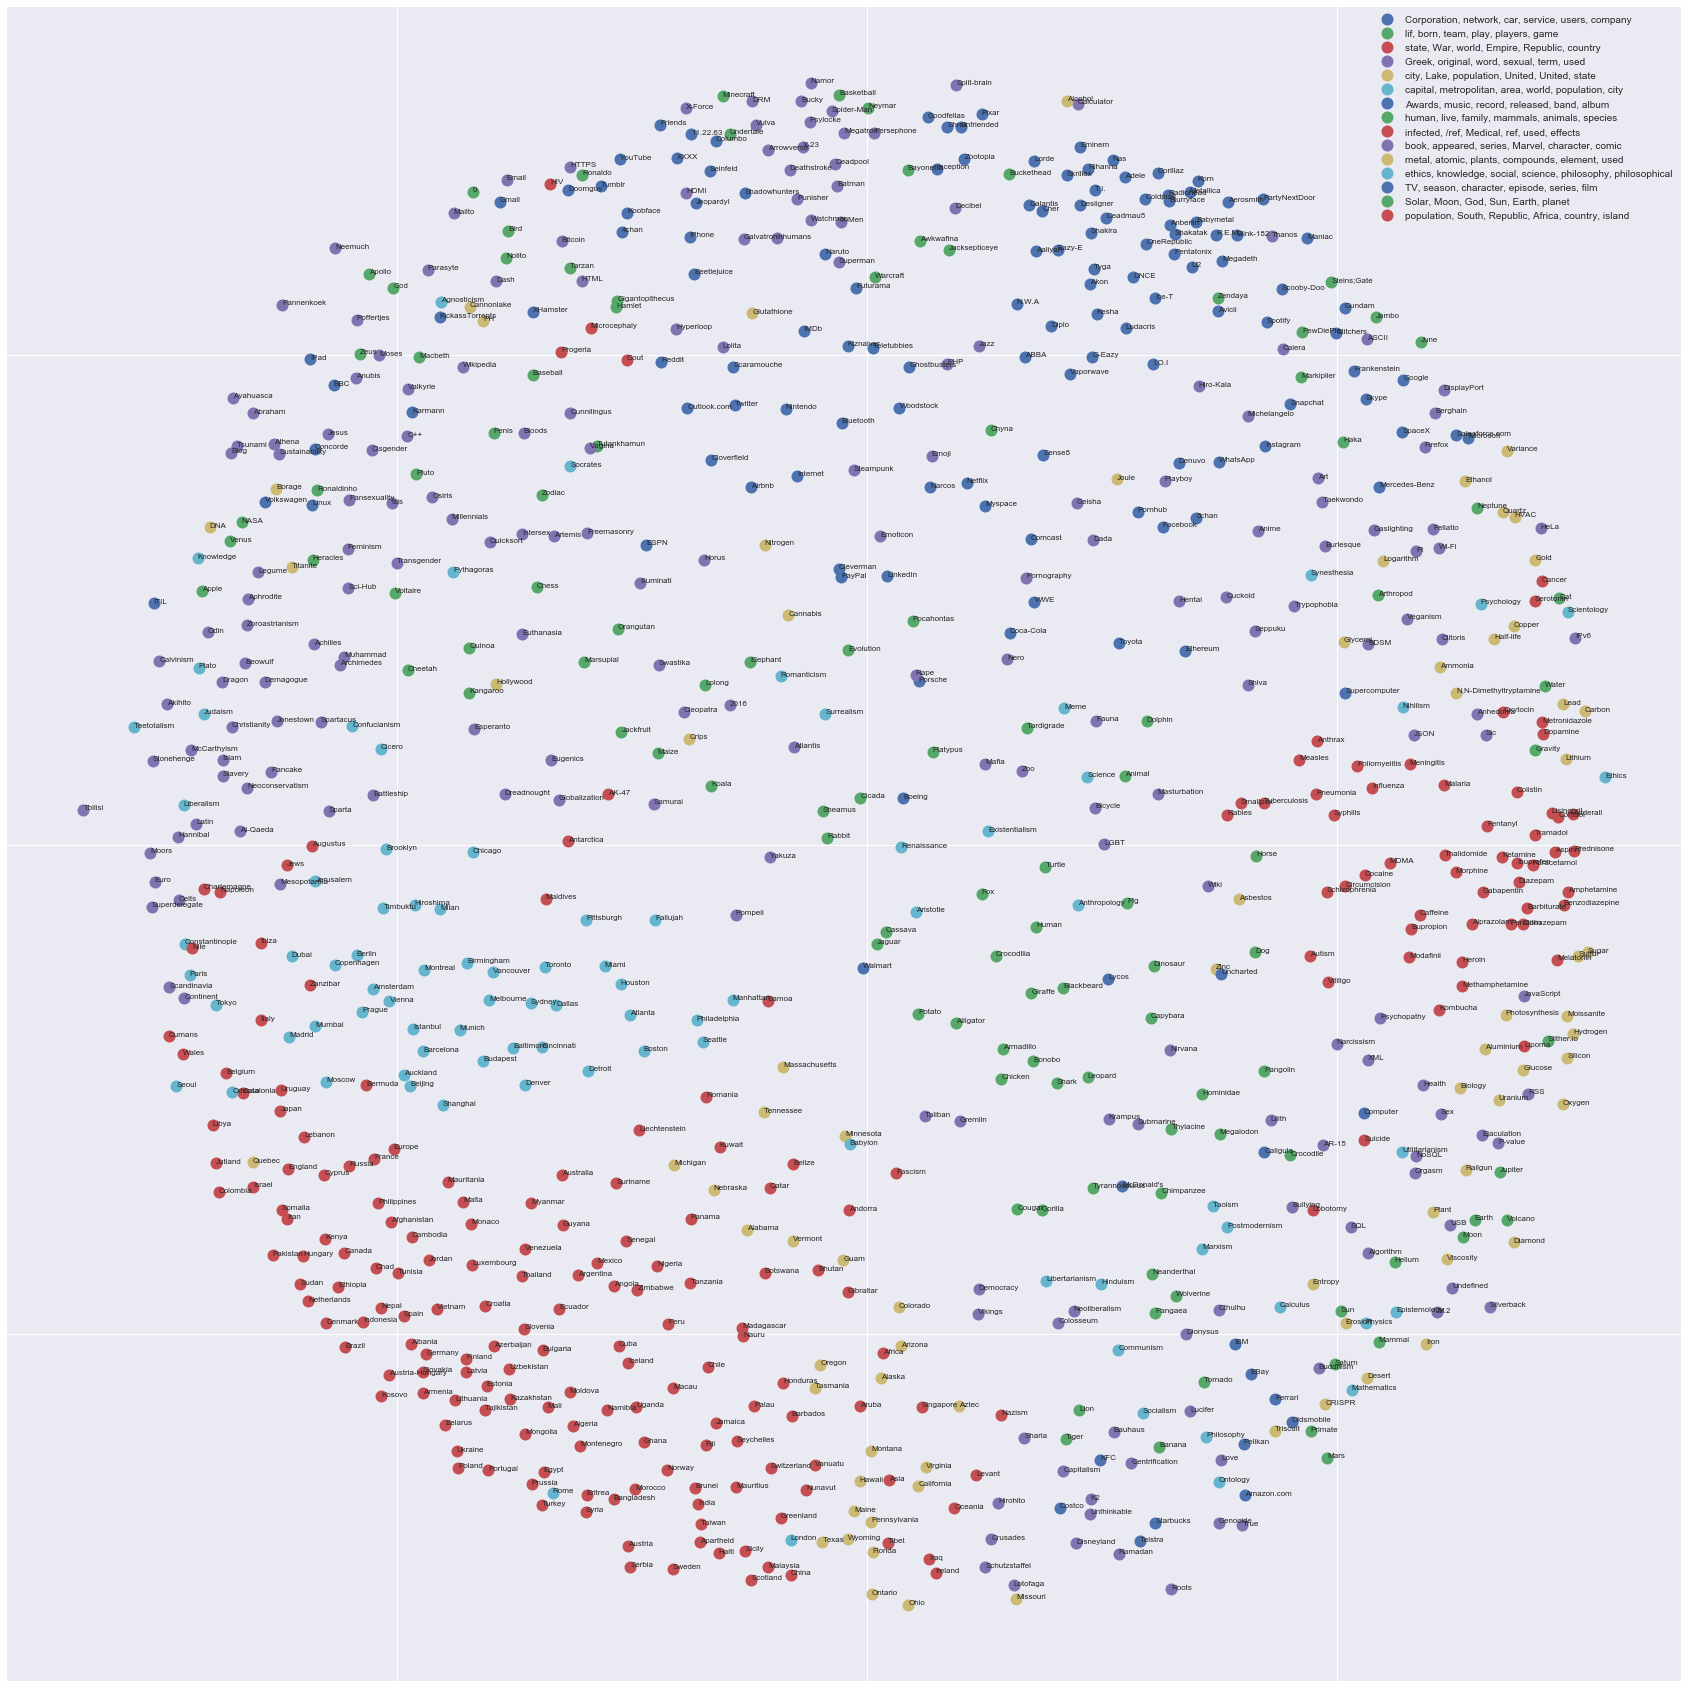

In [310]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df_print = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=df.name)) 

#group by cluster
groups = df_print.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(30, 30)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df_print.ix[i]['x'], df_print.ix[i]['y'], df_print.ix[i]['title'], size=8)  

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=300)